In [74]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statistics import NormalDist
import glob
from collections import defaultdict

from scipy.stats import ttest_ind

In [2]:

label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']
label_df.head(4)


,subj,bipole,label
0,Epat31,AH3-AH4,1
1,Epat31,AH4-AH5,1
2,Epat31,AH5-AH6,1
3,Epat31,PH1-PH2,1


In [212]:
def split_bipole(bip_df: pd.DataFrame):
    """splits the bipole column of a bipole df
    duplicates rows

    """
    assert 'bipole' in bip_df.columns, "Need bipole column!"

    contact1 = bip_df.bipole.apply(lambda x: x.split("-")[0].strip(" "))
    contact2 = bip_df.bipole.apply(lambda x: x.split("-")[1].strip(" "))
# python resultAggregator.py -s 'Epat38' -p '/mnt/ernie_main/Ghassan/ephys/data/Epat38'
    df2 = bip_df.copy(deep=True)

    bip_df['contact'] = contact1
    df2['contact'] = contact2


    return pd.concat([bip_df,df2])

def map_label(label):
    label = int(label)
    match label:
        case 0:
            return "NIZ"
        case 1:
            return 'SOZ'
        case 2:
            return 'PZ'
        case 3:
            return 'IZ'
        
def merge_label(subj_df: pd.DataFrame, label_df: pd.DataFrame, leftcol: str, rightcol: str ) -> pd.DataFrame:
    """Merges contact label into the subj_df for both stim and response regions

    Args:
        subj_df (pd.DataFrame): dataframe with SPES data, could be CRP, raw SPES, etc
        as long as each row has an entry for a bipole (or monopolar) contact to merge on. 
        ASSUMES 'subj' is a column for sanity checks.
       
        label_df (pd.DataFrame): labels designating 'SOZ', 'NIZ', 'PZ', should be originating 
        from the 'all_pats_bipole.csv', may contain more than one subject, but ASSUMES 'subj' is a column.

        leftcol (str): column of subject bipoles, could be stim, or resp, will be renamed
        'leftcol_label'

       merge_labeleturns:
        pd.DataFrame: subj df with columns for labels
    """
    assert 'subj' in subj_df.columns, "Need a 'subj' column! in subj_df"
    assert 'subj' in label_df.columns, "Needa 'subj' column in label_df"
    assert 'label' in label_df.columns, "Need a label to merge into subj_df, check label_df!"
    assert subj_df.subj.values[0] in set(label_df.subj.values) ,"Subject missing from label df!"
    assert len(set(subj_df.subj)) == 1, 'Can only merge one subject at a time!'
    og_rows = subj_df.shape[0]
    subj = subj_df.subj.values[0]
    label_df = label_df[label_df.subj == subj]
    reg_map = defaultdict(lambda: "UNLABELED")
    reg_map.update({reg:label for reg,label in label_df[[rightcol,'label']].values})
    subj_df[ f'{leftcol}_label'] = subj_df[leftcol].apply(lambda x: reg_map[x])  # subj_df = subj_df.merge(label_df[[rightcol, 'label']], left_on=leftcol, right_on=rightcol)
    assert og_rows >= subj_df.shape[0], f"For {subj}\n\t\texpected at most {og_rows}, after merge: {subj_df.shape[0]} rows detected"
    return subj_df



label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']



label_df = split_bipole(label_df)

label_df.label = label_df.label.apply(map_label)
label_df['bipole'] = label_df.bipole.apply(lambda x: x.replace(" ", ""))

relabel = defaultdict(lambda:"NIZ")
relabel['SOZ'] = 'SOZ' 
label_df['label'] = [relabel[x] for x in label_df.label.values]



In [214]:
RES_FILES = glob.glob('/mnt/ernie_main/Ghassan/ephys/data/*pat*/*pat*_stim.csv')
print(RES_FILES)
import pdb
def agg_subject_results(result_files: list[str], label_df: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    expected_rows = 0
    for f in result_files:
        res_df = pd.read_csv(f)
        subj = res_df.subj.values[0]
        expected_rows += res_df.shape[0]
        tmp = merge_label(res_df,label_df, 'resp_reg', 'contact')
        merge_df = merge_label(tmp, label_df, 'stim_reg', 'bipole')        
        dfs.append(merge_df)
    dfs = pd.concat(dfs)
    dfs = dfs[dfs.stim_reg_label != "UNLABELED"]
    dfs = dfs[dfs.resp_reg_label != "UNLABELED"]
    assert expected_rows >= dfs.shape[0], f"Expected at most {expected_rows}, got {dfs.shape[0]}\n\t\t diff: {expected_rows - dfs.shape[0]}"
    print(f"{len(set(dfs.subj))} subjects, total of {dfs.shape[0]} trials, dropped: {expected_rows - dfs.shape[0]}")
    return dfs

res_df = agg_subject_results(RES_FILES, label_df.drop_duplicates())


['/mnt/ernie_main/Ghassan/ephys/data/Epat26/Epat26_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat30/Spat30_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat27/Epat27_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat30/Epat30_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat31/Epat31_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat31/Spat31_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat52/Spat52_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat34/Spat34_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat35/Epat35_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat37/Epat37_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat37/Spat37_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat38/Epat38_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat39/Epat39_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat43/Epat43_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat36/Spat36_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat37/Spat37_stim.csv']
15 subjects, total of 2

In [218]:
dist_df = pd.read_csv('/mnt/ernie_main/000_Data/SEEG/SEEG_EyesClosed_RestingState/labels/all_pats_euc_dist_list.csv',header=None)
dist_df.columns = ['subj', 'bipole1', 'bipole2','dist']
subj_set = set(res_df.subj)
dist_df = dist_df[dist_df.subj.isin(subj_set)]

In [219]:
dist_df['monopole1'] = dist_df.bipole2.apply(lambda x : x.split("-")[0])
dist_df['monopole2'] = dist_df.bipole2.apply(lambda x : x.split("-")[1])


In [220]:
res_df

,Unnamed: 0,alphas,TR,resp_reg,alpha_prime,explained_variance,stim_reg,ma,subj,resp_reg_label,stim_reg_label
0,0,-388.625444,0.714844,LA1,-1.061818,0.721774,LAC3-LAC4,5mA,Epat26,NIZ,NIZ
1,1,-82.506352,0.714844,LA1,-0.225427,0.060395,LAC3-LAC4,5mA,Epat26,NIZ,NIZ
2,2,-93.240199,0.714844,LA1,-0.254755,0.066528,LAC3-LAC4,5mA,Epat26,NIZ,NIZ
3,3,170.587074,0.714844,LA1,0.466085,0.275502,LAC3-LAC4,5mA,Epat26,NIZ,NIZ
4,4,-139.850046,0.714844,LA1,-0.382104,0.163243,LAC3-LAC4,5mA,Epat26,NIZ,NIZ
...,...,...,...,...,...,...,...,...,...,...,...
266947,5,-82.915917,0.929688,RTT9,-0.174193,0.018511,ROF13-ROF14,1mA,Spat37,NIZ,NIZ
266948,6,-681.212789,0.929688,RTT9,-1.431119,0.408846,ROF13-ROF14,1mA,Spat37,NIZ,NIZ
266949,7,-717.013584,0.929688,RTT9,-1.506331,0.290499,ROF13-ROF14,1mA,Spat37,NIZ,NIZ
266950,8,-301.200589,0.929688,RTT9,-0.632774,0.152170,ROF13-ROF14,1mA,Spat37,NIZ,NIZ


In [221]:
dist_map = defaultdict(lambda: -1)
dist_map.update({f'{subj}-{bip1}-{mono1}':d for subj,bip1,mono1,d in dist_df[['subj','bipole1','monopole1','dist']].values})
dist_map.update({f'{subj}-{bip1}-{mono2}':d for subj,bip1,mono2,d in dist_df[['subj','bipole1','monopole2','dist']].values})

tst_df = res_df.copy(deep=True)
tst_df['dist'] = [dist_map[f"{subj}-{stim_reg}-{resp_reg}"] for subj,stim_reg,resp_reg in tst_df[['subj','stim_reg','resp_reg']].values]

In [222]:
resdist_df = tst_df

In [223]:
resdist_df

,Unnamed: 0,alphas,TR,resp_reg,alpha_prime,explained_variance,stim_reg,ma,subj,resp_reg_label,stim_reg_label,dist
0,0,-388.625444,0.714844,LA1,-1.061818,0.721774,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,70.6798
1,1,-82.506352,0.714844,LA1,-0.225427,0.060395,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,70.6798
2,2,-93.240199,0.714844,LA1,-0.254755,0.066528,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,70.6798
3,3,170.587074,0.714844,LA1,0.466085,0.275502,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,70.6798
4,4,-139.850046,0.714844,LA1,-0.382104,0.163243,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,70.6798
...,...,...,...,...,...,...,...,...,...,...,...,...
266947,5,-82.915917,0.929688,RTT9,-0.174193,0.018511,ROF13-ROF14,1mA,Spat37,NIZ,NIZ,36.1295
266948,6,-681.212789,0.929688,RTT9,-1.431119,0.408846,ROF13-ROF14,1mA,Spat37,NIZ,NIZ,36.1295
266949,7,-717.013584,0.929688,RTT9,-1.506331,0.290499,ROF13-ROF14,1mA,Spat37,NIZ,NIZ,36.1295
266950,8,-301.200589,0.929688,RTT9,-0.632774,0.152170,ROF13-ROF14,1mA,Spat37,NIZ,NIZ,36.1295


In [224]:
#Filtera conditions
resdist_df = resdist_df[resdist_df.dist > 5]
resdist_df = resdist_df[resdist_df.ma == '3mA']
#resdist_df = resdist_df[resdist_df.TR > 20]

In [225]:
cols = ['subj','stim_reg','resp_reg','alphas','alpha_prime','TR','dist', "resp_reg_label","stim_reg_label"]
group = resdist_df[cols].groupby(['subj','resp_reg', 'stim_reg',"resp_reg_label","stim_reg_label"])
group_df = group.mean()

In [226]:
resdist_df['stim_rel'] = [f"{a}-{b}" for a,b in resdist_df[['resp_reg_label','stim_reg_label']].values]
resdist_df['stim_sesh'] = [f"{stim}-{resp}" for stim, resp in resdist_df[['stim_reg','resp_reg']].values ]
stim_rel_map = {f"{subj}-{stim_sesh}":stim_rel for subj,stim_sesh,stim_rel in resdist_df[['subj','stim_sesh','stim_rel']].values}

In [227]:

tmp =resdist_df[['subj','explained_variance', 'dist', 'stim_sesh']].groupby(["subj","stim_sesh"]).mean().reset_index()
tmp['stim_rel'] = [stim_rel_map[f'{subj}-{stim_sesh}'] for subj,stim_sesh in tmp[['subj', 'stim_sesh']].values]
ev_dist_df = tmp

In [228]:
ev_dist_df

,subj,stim_sesh,explained_variance,dist,stim_rel
0,Epat26,LA1-LA2-LA4,0.808617,6.7946,NIZ-NIZ
1,Epat26,LA1-LA2-LA5,0.844006,10.3208,NIZ-NIZ
2,Epat26,LA1-LA2-LA6,0.855749,13.9337,NIZ-NIZ
3,Epat26,LA1-LA2-LA7,0.876790,17.5366,NIZ-NIZ
4,Epat26,LA1-LA2-LAC1,0.318576,69.0552,NIZ-NIZ
...,...,...,...,...,...
83651,Spat52,RTF6-RTF7-RH7,0.165061,28.6646,NIZ-NIZ
83652,Spat52,RTF6-RTF7-RTF1,0.887647,17.4268,NIZ-NIZ
83653,Spat52,RTF6-RTF7-RTF2,0.922448,17.4268,NIZ-NIZ
83654,Spat52,RTF6-RTF7-RTF3,0.864253,14.1251,NIZ-NIZ


tmp.shape

In [229]:
# get NIZ stats
def get_NIZ_stats(df):
    return
sub_niz = dict()
sub_niz_tr = dict()
sub_niz_ev = dict()
for subj in set(resdist_df.subj):
    sub_df = resdist_df[resdist_df.subj==subj]
    niz_sub_df = sub_df[sub_df.stim_rel =="NIZ-NIZ"]
    mu = niz_sub_df.alpha_prime.mean()
    var = niz_sub_df.alpha_prime.std()
    sub_niz[subj] = (mu, var)

    
    mu = niz_sub_df.TR.mean()
    var = niz_sub_df.TR.std()
    sub_niz_tr[subj] = (mu, var)
    
    mu = niz_sub_df.explained_variance.mean()
    var = niz_sub_df.explained_variance.std()   
    sub_niz_ev[subj] = (mu, var)



print(f'TR stats:{  sub_niz_tr }')

print( f'alpha_prime stats: { sub_niz }' )



TR stats:{'Epat39': (0.34876966411564625, 0.30603941479777846), 'Epat26': (0.2789481494413408, 0.26688372403911254), 'Epat31': (0.41220548373644705, 0.2921829168899633), 'Epat35': (0.3290232053306092, 0.29689772304567474), 'Epat43': (0.39237539556962026, 0.3043813042602722), 'Epat38': (0.34067425111674865, 0.3075424783648187), 'Spat34': (0.3068888947695056, 0.29421224761294434), 'Spat52': (0.3811703821656051, 0.2970376012284116), 'Epat37': (0.318190650782577, 0.30117283502153364), 'Spat31': (0.21504283462982832, 0.2713433536127782), 'Spat36': (0.3699459114840408, 0.30302756880016013), 'Spat37': (0.36033033288043476, 0.30240208493183873), 'Spat30': (0.3031807830327567, 0.29154790077614995), 'Epat27': (0.27783885024333477, 0.2844239048255683), 'Epat30': (0.29697416899741824, 0.2832158797622848)}
alpha_prime stats: {'Epat39': (0.30741446236162373, 27.25926322378173), 'Epat26': (0.024281434307621735, 7.217672643034074), 'Epat31': (-0.39713015982218997, 11.822586509492965), 'Epat35': (-0.09

In [230]:
# z score
experiment_df = resdist_df #[resdist_df.stim_rel.isin(['SOZ-SOZ','NIZ-SOZ','SOZ-NIZ'])]
dfs = []
for subj in set(experiment_df.subj):
    tmp = experiment_df[experiment_df.subj == subj]
    
    dist = NormalDist(*sub_niz[subj])
    tmp['alpha_z'] = tmp.alpha_prime.apply(dist.zscore)

    tr_dist = NormalDist(*sub_niz_tr[subj])
    tmp['TR_z'] = tmp.TR.apply(tr_dist.zscore)

    ev_dist = NormalDist(*sub_niz_ev[subj])
    tmp['ev_z'] = tmp.explained_variance.apply(ev_dist.zscore)
    dfs.append(tmp)

z_dfs = pd.concat(dfs)


    

/tmp/ipykernel_327072/853529833.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['alpha_z'] = tmp.alpha_prime.apply(dist.zscore)
/tmp/ipykernel_327072/853529833.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['TR_z'] = tmp.TR.apply(tr_dist.zscore)
/tmp/ipykernel_327072/853529833.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [231]:
tmp = z_dfs[['subj','alpha_z','TR_z','explained_variance', 'stim_rel','dist']]
zgroup = tmp.groupby(['subj','stim_rel']).mean()
zgroup_df = zgroup.reset_index()
zgroup_df

,subj,stim_rel,alpha_z,TR_z,explained_variance,dist
0,Epat26,NIZ-NIZ,-4.937081e-19,1.198793e-17,0.469723,54.329755
1,Epat26,NIZ-SOZ,7.924204e-02,3.969159e-02,0.483700,52.560780
2,Epat26,SOZ-NIZ,-3.611244e-02,-2.858859e-02,0.467274,54.036395
3,Epat26,SOZ-SOZ,-1.722910e-01,-1.069531e-01,0.585904,32.035435
4,Epat27,NIZ-NIZ,-1.003570e-17,-9.103077e-17,0.469016,56.171759
5,Epat27,NIZ-SOZ,-1.053371e-02,1.773842e-01,0.450379,52.127262
6,Epat27,SOZ-NIZ,-6.761088e-02,9.585823e-02,0.461593,51.869780
7,Epat27,SOZ-SOZ,-1.070389e-01,1.303445e-02,0.531755,37.379003
8,Epat30,NIZ-NIZ,-1.242074e-18,1.131720e-17,0.483249,57.333682
9,Epat30,NIZ-SOZ,-1.262354e-02,4.405087e-02,0.467703,50.211051


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='dist', ylabel='Count'>

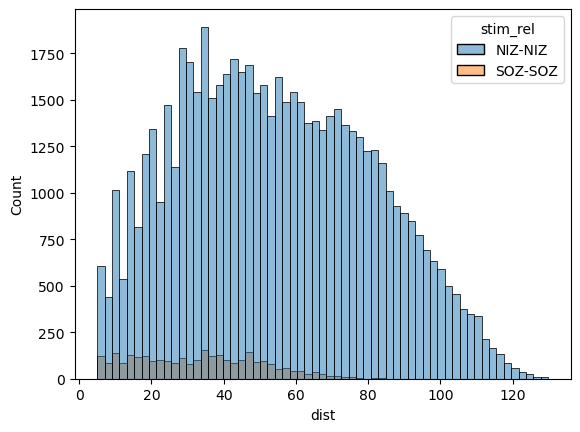

In [232]:
cols = ['NIZ-NIZ', 'SOZ-SOZ']

sns.histplot(ev_dist_df[ev_dist_df.stim_rel.isin(cols)],x='dist', hue='stim_rel')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

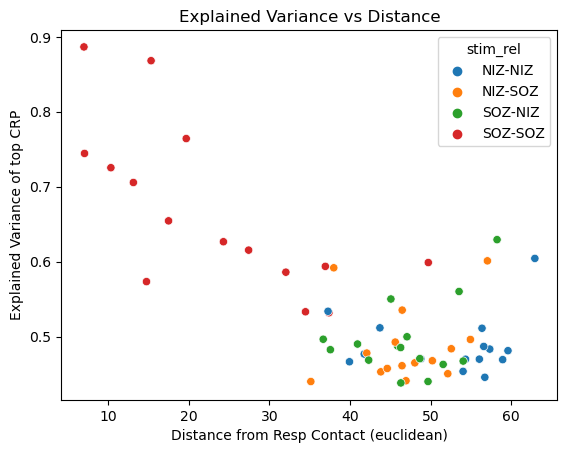

In [233]:
plot_df = ev_dist_df[['subj','stim_rel','dist','explained_variance']].groupby(['subj','stim_rel']).mean().reset_index()
# plot_df = ev_dist_df
cols = ['NIZ-NIZ', 'NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ']
sns.scatterplot(data=plot_df[plot_df.stim_rel.isin(cols)], x='dist', y='explained_variance', hue='stim_rel')
plt.title("Explained Variance vs Distance")
plt.xlabel("Distance from Resp Contact (euclidean)")
plt.ylabel("Explained Variance of top CRP")
plt.savefig(f"viz/ev_by_stim_rel.pdf",transparent=True)

In [22]:
pd.__version__

'2.1.0'

In [25]:
# sns.lineplot(data=zgroup_df, x='dist', y='explained_variance', hue='stim_rel')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

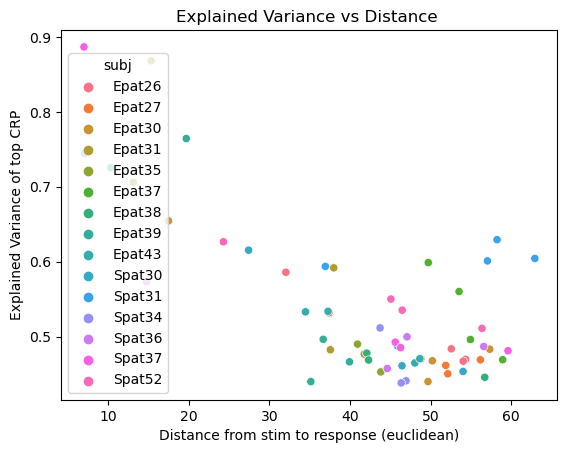

In [234]:

sns.scatterplot(data=zgroup_df, x='dist', y='explained_variance', hue='subj')
plt.title("Explained Variance vs Distance ")
plt.xlabel("Distance from stim to response (euclidean)")
plt.ylabel("Explained Variance of top CRP")
plt.savefig(f"viz/ev_dist_from_soz.pdf",transparent=True)

In [235]:
tst_df = zgroup_df[zgroup_df.subj !='Spat34']
from scipy.stats import ttest_1samp

In [49]:
plt.rcParams.update({'font.size': 16})


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

SOZ mean : 0.34778548846792406 vs NIZ->SOZ mean -0.007852650443973597
SOZ->NIZ: -0.003537916421246163 vs NIZ->SOZ mean -0.007852650443973597
TtestResult(statistic=-2.2852078530578153, pvalue=0.0384118305812561, df=14.0)


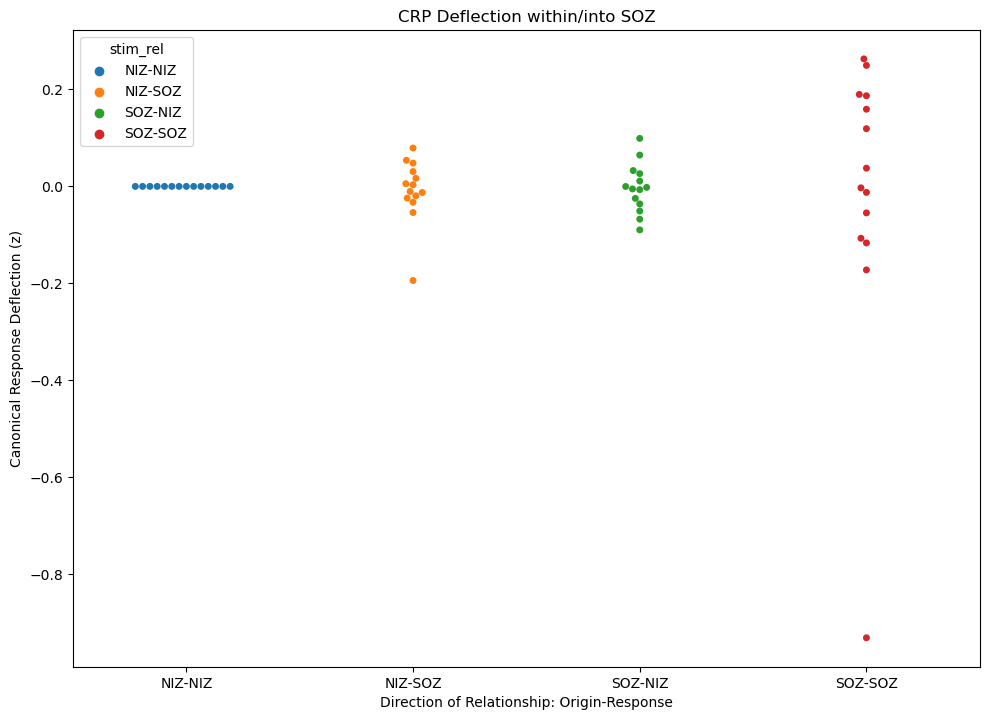

In [236]:
fig, ax = plt.subplots(figsize=[11.7,8.27])


ax = sns.swarmplot(tst_df[tst_df.stim_rel.isin(cols)], x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].alpha_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].alpha_z
c = tst_df[tst_df.stim_rel == 'SOZ-NIZ'].alpha_z
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].alpha_z

b= ttest_1samp(b,0)
print(f"SOZ mean : {np.mean(b)} vs NIZ->SOZ mean {np.mean(a)}")

print(f"SOZ->NIZ: {np.mean(c)} vs NIZ->SOZ mean {np.mean(a)}")
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Deflection (z)")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.title("CRP Deflection within/into SOZ")
plt.savefig("viz/relabel_crp_alphaz_focus.pdf", transparent=True)

In [ ]:
tst_df

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

SOZ mean : 0.34778548846792406 vs NIZ->SOZ mean -0.007852650443973597
SOZ->NIZ: -0.003537916421246163 vs NIZ->SOZ mean -0.007852650443973597
TtestResult(statistic=-2.2852078530578153, pvalue=0.0384118305812561, df=14.0)


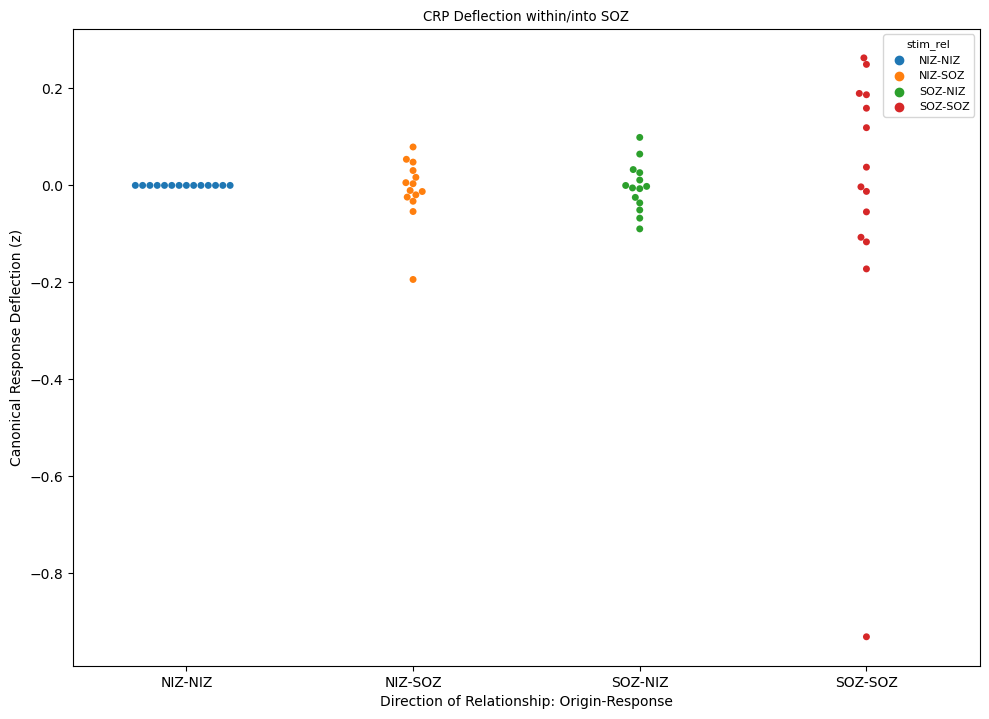

In [237]:
fig, ax = plt.subplots(figsize=[11.7,8.27])
plt.rcParams.update({'font.size': 8})


ax = sns.swarmplot(tst_df, x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].alpha_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].alpha_z
c = tst_df[tst_df.stim_rel == 'SOZ-NIZ'].alpha_z
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].alpha_z

b= ttest_1samp(b,0)
print(f"SOZ mean : {np.mean(b)} vs NIZ->SOZ mean {np.mean(a)}")

print(f"SOZ->NIZ: {np.mean(c)} vs NIZ->SOZ mean {np.mean(a)}")
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Deflection (z)")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.title("CRP Deflection within/into SOZ")
plt.savefig("viz/relabel_crp_alphaz_full.pdf", transparent=True)

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

NIZ-SOZ zscore 0.02204392782370516
SOZ-SOZ zscore 0.18287448933753317
TtestResult(statistic=-1.0838838867763791, pvalue=0.28836547528458534, df=26.0)


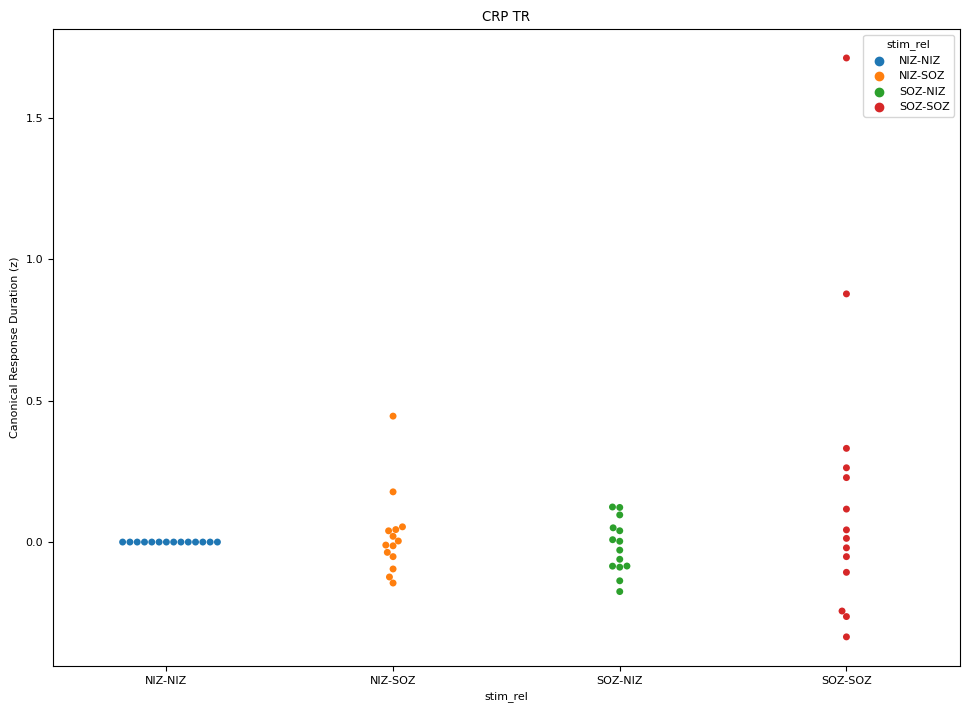

In [238]:
fig, ax = plt.subplots(figsize=[11.7,8.27])


ax = sns.swarmplot(tst_df, x='stim_rel', y='TR_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].TR_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].TR_z
c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].TR_z
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].TR_z

# b= ttest_1samp(b,0)
# print(b)
print(f"NIZ-SOZ zscore {np.mean(a)}")
print(f"SOZ-SOZ zscore {np.mean(b)}")
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Duration (z)")
plt.title("CRP TR")
plt.savefig("viz/relabel_crp_TRz.pdf",transparent=True)

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

0.6616302080571604
TtestResult(statistic=-5.1223786547553, pvalue=2.4337377734216055e-05, df=26.0)


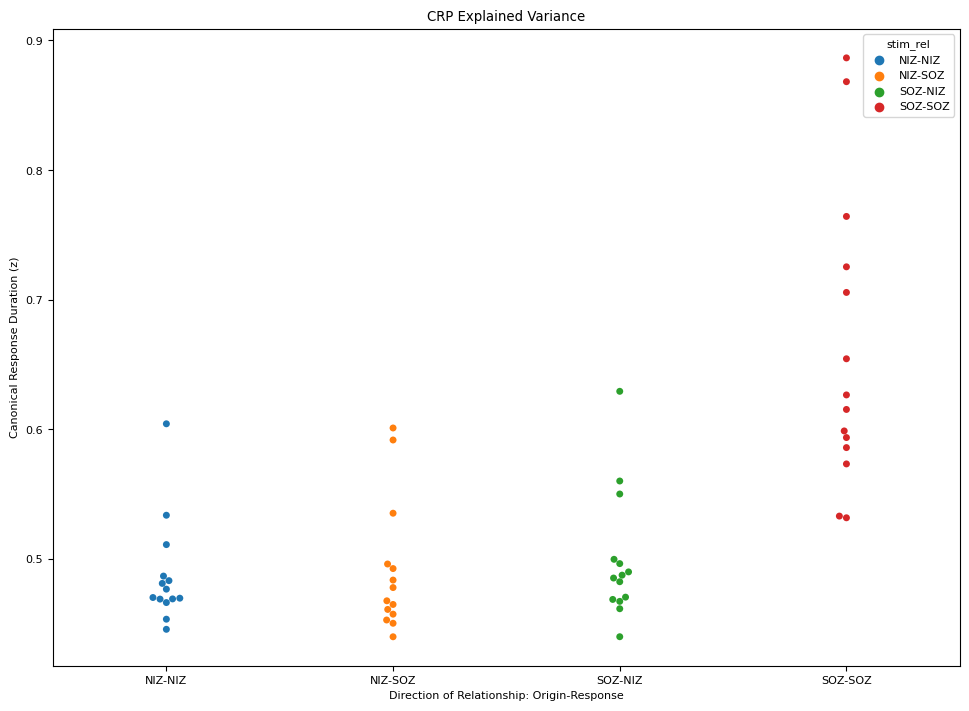

In [239]:

fig, ax = plt.subplots(figsize=[11.7,8.27])


ax = sns.swarmplot(tst_df, x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].explained_variance
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].explained_variance
c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].explained_variance
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].explained_variance

# b= ttest_1samp(b,0)
print(np.mean(b))
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Duration (z)")
plt.title("CRP Explained Variance")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.savefig("viz/relabel_CRP_ev_full.pdf", transparent=True)

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

0.6616302080571604
TtestResult(statistic=-5.1223786547553, pvalue=2.4337377734216055e-05, df=26.0)


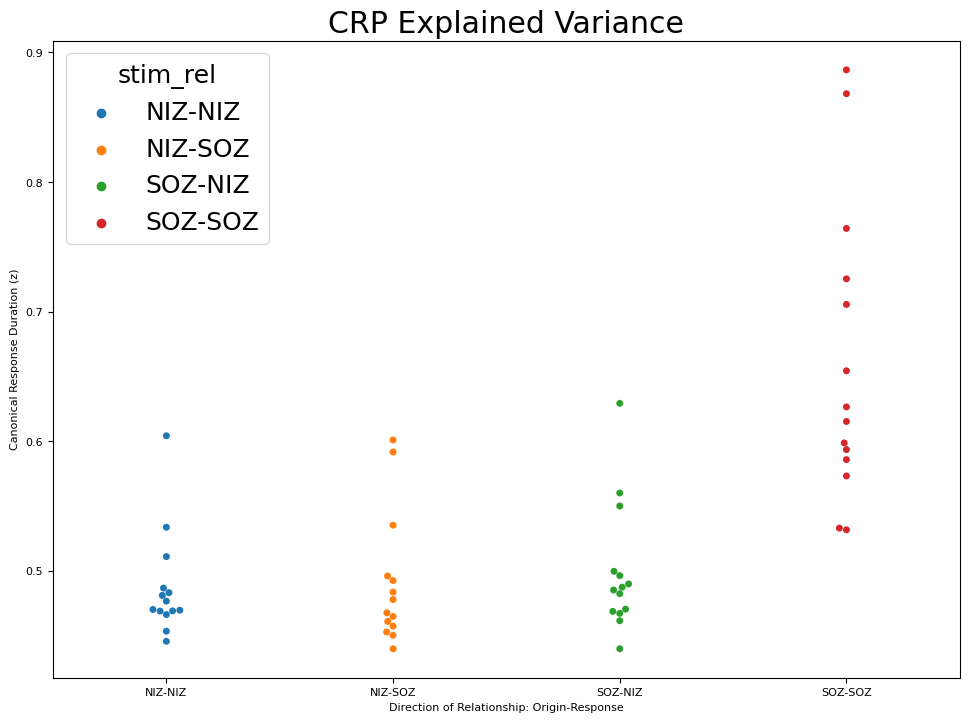

In [240]:
fig, ax = plt.subplots(figsize=[11.7,8.27])
plt.rcParams.update({'font.size': 18})


ax = sns.swarmplot(tst_df[tst_df.stim_rel.isin(cols)], x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].explained_variance
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].explained_variance
c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].explained_variance
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].explained_variance

# b= ttest_1samp(b,0)
print(np.mean(b))
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Duration (z)")
plt.title("CRP Explained Variance")
plt.xlabel("Direction of Relationship: Origin-Response")

plt.savefig("viz/relabel_CRP_ev_focus.pdf", transparent=True)

In [ ]:
sns.histplot(data=group_df, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
plt.title("Alpha prime Across all locations")

In [ ]:
tst = group_df.reset_index()
tst = tst[tst.resp_reg_label =='SOZ']
sns.histplot(data=tst, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
plt.title("Alpha prime in SOZ locations")

In [ ]:
tst = group_df.reset_index()
tst = tst[tst.resp_reg_label =='PZ']
sns.histplot(data=tst, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
plt.title("Alpha prime in PZ locations")


In [ ]:
sns.violinplot(plot_df[plot_df.subj==plot_df.subj.values[0]],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)


In [ ]:

ax = sns.violinplot(plot_df[plot_df.subj=='Epat27'],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)
ax.set_ylim(10e-8, 10e3)
plt.title("Epat 27")

In [ ]:
plot_df